# Preprocess

The preprocessing steps consist of merging all retrieved files into one xarray dataset and extracting the spatial and temporal average of the event of interest.

## Merge

Here it is shown how all retrieved files are loaded into one xarray dataset, for both SEAS5 and for ERA5. 

### SEAS5
All retrieved seasonal forecasts are loaded into one xarray dataset. The amount of files retrieved depends on the temporal extent of the extreme event that is being analyzed (i.e are you looking at a monthly average or a seasonal average?). For the Siberian heatwave, we have retrieved 105 files (one for each of the 35 years and for each of the three lead times, ([see Retrieve](../1.Download/1.Retrieve.ipynb)). For the UK, we are able to use more forecasts, because the target month is shorter: one month as compared to three months for the Siberian example. We retrieved 5 leadtimes x 35 = 175 files.  

Each netcdf file contains 25 ensemble members, hence has the dimensions lat, lon, number (25 ensembles). Here we create an xarray dataset that also contains the dimensions time (35 years) and leadtime (5 initialization months). To generate this, we loop over lead times, and open all 35 years of the lead time and then concatenate those leadtimes.

In [1]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../../'))
import src.cdsretrieve as retrieve

In [3]:
os.chdir(os.path.abspath('../../../'))
os.getcwd() #print the working directory

'C:\\Users\\Timo\\OneDrive - Loughborough University\\GitHub\\UNSEEN-open'

In [4]:
import xarray as xr
import numpy as np

def merge_SEAS5(folder, target_months):
    init_months, leadtimes = retrieve._get_init_months(target_months)
    print('Lead time: ' + "%.2i" % init_months[0])
    SEAS5_ld1 = xr.open_mfdataset(
        folder + '*' + "%.2i" % init_months[0] + '.nc',
        combine='by_coords')  # Load the first lead time
    SEAS5 = SEAS5_ld1  # Create the xarray dataset to concatenate over
    for init_month in init_months[1:len(init_months)]:  ## Remove the first that we already have
        print(init_month)
        SEAS5_ld = xr.open_mfdataset(
            folder + '*' + "%.2i" % init_month + '.nc',
            combine='by_coords') 
        SEAS5 = xr.concat([SEAS5, SEAS5_ld], dim='leadtime')
    SEAS5 = SEAS5.assign_coords(leadtime = np.arange(len(init_months)) + 2) # assign leadtime coordinates
    return(SEAS5)

In [ ]:
SEAS5_Siberia = merge_SEAS5(folder='../Siberia_example/SEAS5/',
                            target_months=[3, 4, 5])

In [8]:
SEAS5_Siberia

,Array,Chunk
Bytes,387.52 MB,3.31 MB
Shape,"(3, 117, 51, 41, 132)","(1, 3, 51, 41, 132)"
Count,887 Tasks,117 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,387.52 MB,3.31 MB
Shape,"(3, 117, 51, 41, 132)","(1, 3, 51, 41, 132)"
Count,887 Tasks,117 Chunks
Type,float32,numpy.ndarray


In [6]:
SEAS5_California = preprocess.merge_SEAS5(folder ='E:/PhD/California_example/SEAS5/', target_months = [8])

NameError: name 'preprocess' is not defined

You can for example select a the lat, long, time, ensemble member and lead time as follows (add `.load()` to see the values):

In [42]:
a = SEAS5_Siberia.sel(latitude=60,
                  longitude=-10,
                  time='2000-03',
                  number=26,
                  leadtime=3).load()

In [10]:
SEAS5_UK = merge_SEAS5(folder = '../UK_example/SEAS5/', target_months = [2])

Lead time: 01
12
11
10
9


The SEAS5 total precipitation rate is in m/s. You can easily convert this and change the attributes.
Click on the show/hide attributes button to see the assigned attributes.

In [11]:
SEAS5_UK['tprate'] = SEAS5_UK['tprate'] * 1000 * 3600 * 24 ## From m/s to mm/d
SEAS5_UK['tprate'].attrs = {'long_name': 'rainfall',
 'units': 'mm/day',
 'standard_name': 'thickness_of_rainfall_amount'}
SEAS5_UK

,Array,Chunk
Bytes,2.69 MB,15.40 kB
Shape,"(5, 35, 25, 11, 14)","(1, 1, 25, 11, 14)"
Count,1715 Tasks,175 Chunks
Type,float32,numpy.ndarray


### ERA5
For each year a netcdf file is downloaded. They are named ERA5_yyyy, for example ERA5_1981. Therefore, we can load ERA5 by combining all downloaded years:

In [12]:
ERA5_Siberia = xr.open_mfdataset('../Siberia_example/ERA5/ERA5_????.nc',combine='by_coords') ## open the data
ERA5_Siberia

,Array,Chunk
Bytes,2.73 MB,64.94 kB
Shape,"(126, 41, 132)","(3, 41, 132)"
Count,126 Tasks,42 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.73 MB,64.94 kB
Shape,"(126, 41, 132)","(3, 41, 132)"
Count,126 Tasks,42 Chunks
Type,float32,numpy.ndarray


In [13]:
ERA5_UK = xr.open_mfdataset('../UK_example/ERA5/ERA5_????.nc',combine='by_coords') ## open the data
ERA5_UK

,Array,Chunk
Bytes,25.87 kB,616 B
Shape,"(42, 11, 14)","(1, 11, 14)"
Count,126 Tasks,42 Chunks
Type,float32,numpy.ndarray


## Event definition

### Time selection
For the UK, the event of interest is UK February average precipitation. Since we download monthly averages, we do not have to do any preprocessing along the time dimension here. For the Siberian heatwave, we are interested in the March-May average. Therefore we need to take the seasonal average of the monthly timeseries. We cannot take the simple mean of the three months, because they have a different number of days in the months, see [this example](http://xarray.pydata.org/en/stable/examples/monthly-means.html). Therefore we take a weighted average:

In [14]:
month_length = SEAS5_Siberia.time.dt.days_in_month
month_length

<xarray.DataArray 'days_in_month' (time: 117)>
array([31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30,
       31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31,
       30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31,
       31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30,
       31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31,
       30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31,
       31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 1982-03-01 1982-04-01 ... 2020-05-01

In [15]:
# Calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
weights

<xarray.DataArray 'days_in_month' (time: 117)>
array([0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652])
Coordinates:
  * time     (time) datetime64[ns] 1982-03-01 1982-04-01 ... 2020-05-01
    year     (time) int64 1982 1982 1982 1983 1983 ... 2019 2019 2020 2020 2020

In [16]:
# Test that the sum of the weights for the season is 1.0
np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(39)) ## the weight is one for each year

In [30]:
# Calculate the weighted average
SEAS5_Siberia_weighted = (SEAS5_Siberia * weights).groupby('time.year').sum(dim='time', min_count = 3)
SEAS5_Siberia_weighted

<xarray.Dataset>
Dimensions:    (latitude: 41, leadtime: 3, longitude: 132, number: 51, year: 39)
Coordinates:
  * leadtime   (leadtime) int64 2 3 4
  * latitude   (latitude) float32 70.0 69.0 68.0 67.0 ... 33.0 32.0 31.0 30.0
  * number     (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... 118.0 119.0 120.0
  * year       (year) int64 1982 1983 1984 1985 1986 ... 2017 2018 2019 2020
Data variables:
    t2m        (year, leadtime, number, latitude, longitude) float64 268.8 ... 289.9
    d2m        (year, leadtime, number, latitude, longitude) float64 266.1 ... 286.0

Or as function:

In [31]:
def season_mean(ds, years, calendar='standard'):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(years))

    # Calculate the weighted average
    return (ds * weights).groupby('time.year').sum(dim='time', min_count = 3)

In [33]:
ERA5_Siberia_weighted = season_mean(ERA5_Siberia, years = 42)
ERA5_Siberia_weighted

<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 132, year: 42)
Coordinates:
  * latitude   (latitude) float32 70.0 69.0 68.0 67.0 ... 33.0 32.0 31.0 30.0
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... 118.0 119.0 120.0
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2017 2018 2019 2020
Data variables:
    t2m        (year, latitude, longitude) float64 270.5 270.9 ... 289.1 290.6
    d2m        (year, latitude, longitude) float64 267.1 267.4 ... 283.5 284.7

What is the difference between the mean and weighted mean?

Barely visible the difference

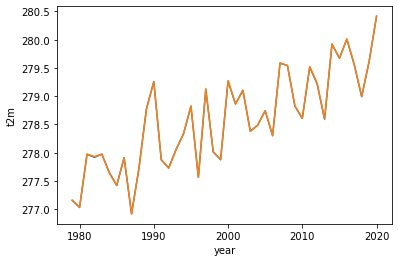

In [34]:
ERA5_Siberia_weighted['t2m'].mean(['longitude', 'latitude']).plot()
ERA5_Siberia['t2m'].groupby('time.year').mean().mean(['longitude','latitude']).plot()

### Spatial selection
What spatial extent defines the event you are analyzing? For the UK, we are looking at country-averaged precipitation. For the Siberian heatwave we define a box (30-70N, -11-120E) over which we average the temperature. 

In [35]:
ERA5_Siberia_events = (
    ERA5_Siberia_weighted['t2m'].sel(  # Select 2 metre temperature
        latitude=slice(70, 30),        # Select the latitudes
        longitude=slice(-11, 120)).    # Select the longitude
    mean(['longitude', 'latitude']))   # And average
ERA5_Siberia_events

<xarray.DataArray 't2m' (year: 42)>
array([277.16074991, 277.03096514, 277.97289103, 277.91908656,
       277.97520289, 277.65083809, 277.41882817, 277.91126484,
       276.91748994, 277.7290794 , 278.77625033, 279.26028161,
       277.8734671 , 277.73297789, 278.05803743, 278.33474762,
       278.8209804 , 277.56676759, 279.12484889, 278.01516085,
       277.87531784, 279.26812975, 278.86348174, 279.10661042,
       278.37979554, 278.49025936, 278.74264131, 278.30305153,
       279.58431666, 279.54500525, 278.82677061, 278.60606811,
       279.51421559, 279.21937005, 278.59269493, 279.92328752,
       279.6721145 , 280.00902662, 279.55917477, 278.99138847,
       279.61443777, 280.41497365])
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019 2020

In addition to the large domain, we select one more specific domain that faced the highest anomalies, also used [here](https://twitter.com/ClimateFlavors/status/1276092906709880837?s=20)

In [36]:
ERA5_Siberia_events_zoomed = (
    ERA5_Siberia_weighted['t2m'].sel(  # Select 2 metre temperature
        latitude=slice(70, 50),        # Select the latitudes
        longitude=slice(65, 120)).    # Select the longitude
    mean(['longitude', 'latitude']))

And we repeat this for the SEAS5 events

In [37]:
SEAS5_Siberia_events = (
    SEAS5_Siberia_weighted['t2m'].sel(
        latitude=slice(70, 30),  
        longitude=slice(-11, 120)).  
    mean(['longitude', 'latitude']))
SEAS5_Siberia_events.load()

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 't2m' (year: 39, leadtime: 3, number: 51)>
array([[[277.70246026, 277.08011538, 277.05805243, ...,          nan,
                  nan,          nan],
        [276.54063304, 277.63527276, 276.53540684, ...,          nan,
                  nan,          nan],
        [276.94382457, 277.22540106, 277.25375804, ...,          nan,
                  nan,          nan]],

       [[276.68638666, 276.64418409, 276.88169219, ...,          nan,
                  nan,          nan],
        [277.06362955, 277.30470221, 276.49967939, ...,          nan,
                  nan,          nan],
        [276.37166345, 276.63563118, 277.05456392, ...,          nan,
                  nan,          nan]],

       [[277.53103277, 277.49691758, 278.32115366, ...,          nan,
                  nan,          nan],
        [277.53911427, 278.11393678, 277.66278741, ...,          nan,
                  nan,          nan],
        [278.24589375, 277.71341079, 277.3067712 , ...,          nan,
                  nan,          nan]],

       ...,

       [[278.78906418, 278.0626699 , 278.09438675, ..., 278.10947691,
         278.27620377, 278.18620179],
        [278.65929139, 277.33954004, 278.65951576, ..., 278.22959696,
         278.32163068, 278.94724957],
        [278.90689211, 277.9030209 , 279.13818072, ..., 278.76767259,
         279.13397914, 277.76992423]],

       [[278.6218426 , 277.95006232, 278.22900254, ..., 277.56330007,
         277.99480916, 277.66857676],
        [278.39808792, 277.65889255, 277.92266928, ..., 278.39390445,
         277.90353039, 278.01793147],
        [278.63429219, 278.11630486, 278.58465727, ..., 277.7081865 ,
         277.73949614, 278.65482764]],

       [[279.28124227, 278.53474142, 278.47436518, ..., 278.93209185,
         278.11716261, 279.3904762 ],
        [277.77935773, 279.15571385, 279.02168652, ..., 279.25803913,
         278.8991169 , 278.72803803],
        [278.54721722, 278.25816177, 279.65502139, ..., 279.01242149,
         278.80174459, 278.23615329]]])
Coordinates:
  * leadtime  (leadtime) int64 2 3 4
  * number    (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * year      (year) int64 1982 1983 1984 1985 1986 ... 2016 2017 2018 2019 2020

In [39]:
SEAS5_Siberia_events_zoomed = (
    SEAS5_Siberia_weighted['t2m'].sel(
        latitude=slice(70, 50),  
        longitude=slice(65, 120)).  
    mean(['longitude', 'latitude']))
SEAS5_Siberia_events_zoomed.load()

<xarray.DataArray 't2m' (year: 39, leadtime: 3, number: 51)>
array([[[269.41349502, 267.46724112, 268.92858923, ...,          nan,
                  nan,          nan],
        [267.30541714, 269.45786213, 267.88083134, ...,          nan,
                  nan,          nan],
        [266.70463988, 269.36559057, 267.85380896, ...,          nan,
                  nan,          nan]],

       [[267.65255078, 267.85459971, 267.93397041, ...,          nan,
                  nan,          nan],
        [267.86908721, 269.16875401, 266.25505375, ...,          nan,
                  nan,          nan],
        [267.37705396, 268.0216673 , 269.216725  , ...,          nan,
                  nan,          nan]],

       [[269.11559244, 270.30993792, 268.97992022, ...,          nan,
                  nan,          nan],
        [268.42632866, 270.23730451, 268.14872887, ...,          nan,
                  nan,          nan],
        [269.91675564, 269.37623754, 268.62430776, ...,          nan,
                  nan,          nan]],

       ...,

       [[270.1395106 , 269.2763681 , 269.63408345, ..., 267.98167445,
         270.99148119, 269.2334804 ],
        [269.47838693, 267.62436995, 270.46814617, ..., 269.60061317,
         269.2030878 , 270.34174847],
        [271.39762301, 268.06102893, 271.27933216, ..., 269.56866515,
         270.64943148, 266.36754614]],

       [[269.32829344, 268.54758963, 269.10385302, ..., 268.03762412,
         269.16690743, 268.41760566],
        [269.09579833, 268.27844902, 268.80430384, ..., 269.38437353,
         269.58112924, 269.15390309],
        [269.2755198 , 269.28402279, 270.34429505, ..., 268.05044769,
         269.01128231, 270.09822017]],

       [[271.35447849, 269.73507649, 269.16852164, ..., 270.77523033,
         268.30803885, 271.87237937],
        [269.33923167, 270.81122764, 269.97102764, ..., 272.56708782,
         270.69195734, 269.90622653],
        [270.37695877, 269.72247595, 272.524012  , ..., 270.04026793,
         269.81585811, 267.24061429]]])
Coordinates:
  * leadtime  (leadtime) int64 2 3 4
  * number    (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * year      (year) int64 1982 1983 1984 1985 1986 ... 2016 2017 2018 2019 2020

In [40]:
SEAS5_Siberia_events.to_dataframe().to_csv('Data/SEAS5_Siberia_events.csv')
ERA5_Siberia_events.to_dataframe().to_csv('Data/ERA5_Siberia_events.csv')

In [41]:
SEAS5_Siberia_events_zoomed.to_dataframe().to_csv('Data/SEAS5_Siberia_events_zoomed.csv')
ERA5_Siberia_events_zoomed.to_dataframe().to_csv('Data/ERA5_Siberia_events_zoomed.csv')

### Pick up from here -> do for ERA and make EOBS EOPtional
From grid to country-averaged timeseries is more complicated.

Here we show how to best extract areal averaged precipitation and test this for UK precipitation within SEAS5 and EOBS. The code is inspired on Matteo De Felice's [blog](http://www.matteodefelice.name/post/aggregating-gridded-data/) -- credits to him!

We create a mask for all 241 countries within [Regionmask](https://regionmask.readthedocs.io/en/stable/#), that has predefined countries from [Natural Earth datasets](http://www.naturalearthdata.com) (shapefiles). We use the mask to go from gridded precipitation to country-averaged timeseries. We select UK, number 31 within the country mask. 

In [2]:
##import packages
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

import xesmf as xe      # Regridding

We load the countries and create a mask for SEAS5 and for EOBS. 

In [62]:
import regionmask       # Masking

countries = regionmask.defined_regions.natural_earth.countries_50
countries

241 'Natural Earth Countries: 50m' Regions (http://www.naturalearthdata.com)
ZW ZM YE VN VE V VU UZ UY FSM MH MP VI GU AS PR US GS IO SH PN AI FK KY BM VG TC MS JE GG IM GB AE UA UG TM TR TN TT TO TG TL TH TZ TJ TW SYR CH S SW SR SS SD LK E KR ZA SO SL SB SK SLO SG SL SC RS SN SA ST RSM WS VC LC KN RW RUS RO QA P PL PH PE PY PG PA PW PK OM N KP NG NE NI NZ NU CK NL AW CW NP NR NA MZ MA WS ME MN MD MC MX MU MR M ML MV MY MW MG MK L LT FL LY LR LS LB LV LA KG KW KO KI KE KZ J J J I IS PAL IRL IRQ IRN INDO IND IS HU HN HT GY GW GN GT GD GR GH D GE GM GA F PM WF MF BL PF NC TF AI FIN FJ ET EST ER GQ SV EG EC DO DM DJ GL FO DK CZ CN CY CU HR CI CR DRC CG KM CO CN MO HK CL TD CF CV CA CM KH MM BI BF BG BN BR BW BiH BO BT BJ BZ B BY BB BD BH BS AZ A AU IOT HM NF AU ARM AR AG AO AND DZ AL AF SG AQ SX

Now we create the mask for the SEAS5 grid. Only one timestep is needed to create the mask. This mask will lateron be used to mask all the timesteps. 

In [63]:
SEAS5_mask = countries.mask(SEAS5_UK.sel(leadtime=2, number=0, time='1982'),
                            lon_name='longitude',
                            lat_name='latitude')

And create a plot to illustrate what the mask looks like. The mask just indicates for each gridcell what country the gridcell belongs to.

<xarray.DataArray 'region' (latitude: 11, longitude: 14)>
array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  31.,  nan,  31.,  31.,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  31.,  31.,  31.,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan, 140.,  31.,  31.,  31.,  31.,  31.,  31.,  nan,
         nan,  nan,  nan],
       [ nan, 140., 140., 140., 140.,  nan,  nan,  nan,  nan,  31.,  31.,
         nan,  nan,  nan],
       [ nan,  nan, 140., 140., 140.,  nan,  nan,  31.,  31.,  31.,  31.,
         31.,  nan,  nan],
       [ nan, 140., 140., 140.,  nan,  nan,  31.,  31.,  31.,  31.,  31.,
         31.,  31.,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  31.,  31.,  31.,
         31.,  31., 160.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan, 160.]])
Coordinates:
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0

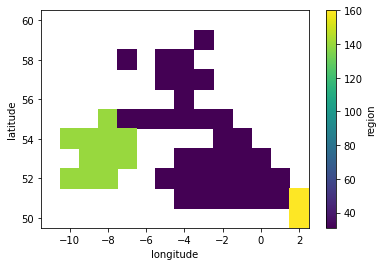

In [64]:
SEAS5_mask
SEAS5_mask.plot()

Now we can extract the UK averaged precipitation within SEAS5 by using the mask index of the UK: `where(SEAS5_mask == UK_index)`. 
So we need to find the index of one of the 241 abbreviations. In this case for the UK use 'GB'. Additionally, if you can't find a country, use `countries.regions` to get the full names of the countries.
 

In [10]:
countries.abbrevs.index('GB')

31

To select the UK average, we select SEAS5 precipitation (tprate), select the gridcells that are within the UK and take the mean over those gridcells. This results in a dataset of February precipitation for 35 years (1981-2016), with 5 leadtimes and 25 ensemble members.

In [65]:
SEAS5_UK = (SEAS5_UK['tprate']
            .where(SEAS5_mask == 31)
            .mean(dim=['latitude', 'longitude']))
SEAS5_UK

NameError: name 'SEAS5' is not defined

However, xarray does not take into account the area of the gridcells in taking the average. Therefore, we have to calculate the [area-weighted mean](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html) of the gridcells. To calculate the area of each gridcell, I use cdo `cdo gridarea infile outfile`. Here I load the generated file:

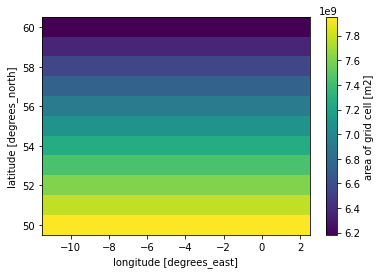

In [12]:
Gridarea_SEAS5 = xr.open_dataset('../UK_example/Gridarea_SEAS5.nc')
Gridarea_SEAS5['cell_area'].plot()

In [13]:
SEAS5_UK_weighted = (SEAS5['tprate']
                  .where(SEAS5_mask == 31)
                  .weighted(Gridarea_SEAS5['cell_area']) 
                  .mean(dim=['latitude', 'longitude'])
                 )
SEAS5_UK_weighted

<xarray.DataArray (leadtime: 5, time: 35, number: 25)>
array([[[1.74715784, 1.91625164, 3.74246331, ..., 2.9025497 ,
         1.87161458, 2.42337871],
        [3.01557164, 1.86355946, 4.23964218, ..., 2.82348107,
         4.08311346, 2.45320866],
        [3.45037457, 3.67373672, 3.19124952, ..., 5.10772697,
         3.83928173, 2.59254324],
        ...,
        [2.91576568, 3.76689869, 4.64815469, ..., 1.61583385,
         3.07634248, 1.633837  ],
        [2.8217756 , 3.61588493, 2.61442489, ..., 3.36894025,
         5.01010622, 3.58215465],
        [2.21954162, 2.46237273, 3.71758684, ..., 3.72850729,
         1.21044478, 3.5506569 ]],

       [[1.08925258, 1.502868  , 3.23383862, ..., 1.49745391,
         2.74434639, 0.98857514],
        [0.96385251, 2.9144073 , 2.14176199, ..., 3.39404417,
         2.837949  , 4.39105086],
        [3.64189637, 3.44186084, 1.96817031, ..., 3.90560029,
         3.78419096, 3.13070979],
        ...,
        [2.46681904, 3.55272741, 3.41184678, ..., 2.58295751,
         3.84194729, 3.71967185],
        [1.96088291, 3.64719353, 2.73561159, ..., 3.56311814,
         2.00379361, 3.89548019],
        [1.89263296, 1.99179138, 2.91457733, ..., 3.37011609,
         3.05092884, 1.89736692]],

       [[1.94362083, 2.4160058 , 1.36431312, ..., 1.78378666,
         1.82209387, 2.42526171],
        [2.57294707, 3.55756557, 2.96458594, ..., 3.26071746,
         2.60226357, 3.13573254],
        [4.13926899, 2.61380816, 3.76440713, ..., 1.87333769,
         1.82042494, 4.46818308],
        ...,
        [2.81221309, 2.69631474, 1.80062933, ..., 2.86429728,
         3.13303958, 3.44787769],
        [2.07369663, 2.03958281, 2.81885547, ..., 2.65322161,
         3.32297921, 2.83923239],
        [3.49884241, 3.63866711, 2.03510114, ..., 3.24500072,
         3.15147085, 2.16834782]],

       [[2.83876303, 3.61651907, 1.0950032 , ..., 1.17176117,
         2.91180608, 2.1047135 ],
        [3.95351432, 1.78778573, 3.08959013, ..., 3.43481603,
         2.72829325, 3.6158294 ],
        [3.13152664, 2.19419128, 3.64975772, ..., 0.83938823,
         4.01702257, 3.46619512],
        ...,
        [2.90135673, 5.59148292, 1.70016201, ..., 2.08532097,
         1.84797942, 2.23519466],
        [4.19777172, 3.74702108, 2.8748067 , ..., 1.88071816,
         0.62889528, 2.79973163],
        [1.51194718, 3.07317605, 2.05956574, ..., 2.53950207,
         4.70096128, 2.04542173]],

       [[3.15063505, 3.23490175, 2.60923731, ..., 4.27225421,
         1.29816875, 1.42799228],
        [2.21017692, 3.32458317, 2.3819878 , ..., 2.53619218,
         4.24655687, 3.21280586],
        [4.07655988, 2.07606666, 1.75961194, ..., 4.47653645,
         1.81676988, 4.21655002],
        ...,
        [1.82563235, 3.10218576, 2.46347745, ..., 1.28711195,
         2.36333743, 2.26540939],
        [4.63821163, 4.43540009, 2.37741808, ..., 4.44346938,
         1.27125796, 2.63467098],
        [3.12914205, 2.58186504, 2.11029128, ..., 3.6635387 ,
         1.68374372, 1.9288108 ]]])
Coordinates:
  * time      (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2016-02-01
  * number    (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * leadtime  (leadtime) int64 2 3 4 5 6

What is the difference between the weighted and non-weighted average?

I plot the UK average for ensemble member 0 and leadtime 2

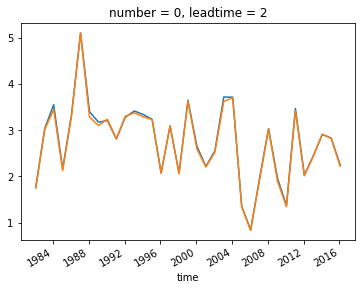

In [14]:
SEAS5_UK.sel(leadtime=2,number=0).plot()
SEAS5_UK_weighted.sel(leadtime=2,number=0).plot()


And a scatter plot of all ensemble members, leadtimes and years also shows little influence

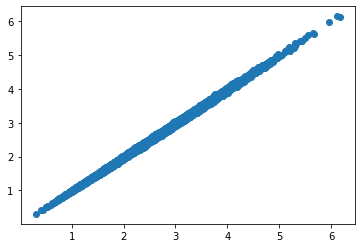

In [15]:
plt.scatter(SEAS5_UK.values.flatten(),SEAS5_UK_weighted.values.flatten())

### EOBS
Same for EOBS. Because this is a larger domain on higher resolution, there are more countries and they look more realistic.

<xarray.DataArray 'region' (latitude: 201, longitude: 464)>
array([[ nan,  nan,  nan, ..., 144., 144., 144.],
       [ nan,  nan,  nan, ..., 144., 144., 144.],
       [ nan,  nan,  nan, ..., 144., 144., 144.],
       ...,
       [181., 181., 181., ...,  nan,  nan,  nan],
       [181., 181., 181., ...,  nan,  nan,  nan],
       [181., 181., 181., ...,  nan,  nan,  nan]])
Coordinates:
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38

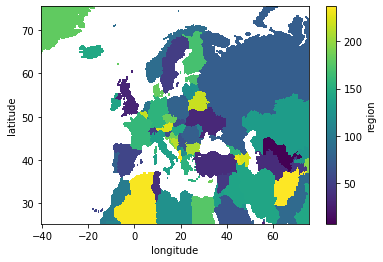

In [52]:
EOBS_mask = countries.mask(EOBS.sel(time='1982'),
                            lon_name='longitude',
                            lat_name='latitude')
EOBS_mask.plot()
EOBS_mask

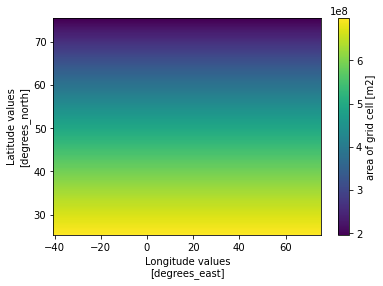

In [53]:
Gridarea_EOBS = xr.open_dataset('../UK_example/Gridarea_EOBS.nc')
Gridarea_EOBS['cell_area'].plot()

<xarray.DataArray (time: 71)>
array([4.0112636 , 3.19827003, 1.11268281, 1.61090816, 2.69306677,
       2.31978493, 0.98650601, 2.63477555, 3.63657055, 0.52167151,
       2.50233819, 2.93969127, 2.06443877, 0.99136675, 1.01560624,
       0.6154935 , 3.93636015, 3.39010865, 1.53137533, 2.15598489,
       3.32269875, 1.78223544, 2.45083221, 2.03587884, 3.3849171 ,
       1.08231163, 1.76152991, 4.20162284, 2.66144679, 1.6568065 ,
       2.91595009, 2.0847285 , 2.17290317, 1.39570346, 2.22253168,
       1.05645274, 0.45730501, 2.02864268, 2.73456517, 4.08896735,
       6.21272081, 2.17751273, 2.52523671, 0.85118189, 2.77141892,
       4.3647128 , 3.00077761, 5.26563969, 2.21997571, 2.63596739,
       4.05858217, 3.15371361, 5.65114533, 1.43401958, 1.96796786,
       2.000555  , 1.87548527, 3.55486921, 2.31611654, 1.74042428,
       2.21678709, 3.55429198, 1.4882801 , 1.77628824, 5.3601659 ,
       2.39871296, 3.39117348, 2.92421785, 1.5737706 , 1.85412429,
       4.91373273])
Coordinates:
  * time     (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2020-02-29

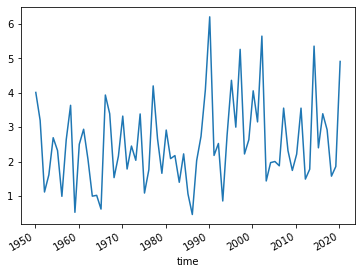

In [54]:
EOBS_UK_weighted = (EOBS['rr']
                  .where(EOBS_mask == 31)
                  .weighted(Gridarea_EOBS['cell_area']) 
                  .mean(dim=['latitude', 'longitude'])
                 )
EOBS_UK_weighted
EOBS_UK_weighted.plot()

#### Save the datasets


In [55]:
SEAS5_UK_weighted.to_netcdf('Data/SEAS5_UK_weighted.nc')
EOBS_UK_weighted.to_netcdf('Data/EOBS_UK_weighted.nc') ## save as netcdf
EOBS_UK_weighted.to_pandas().to_csv('Data/EOBS_UK_weighted.csv') ## and save as csv. 

In [59]:
SEAS5_UK_weighted.close()
EOBS_UK_weighted.close()

#### Illustrate the SEAS5 and EOBS masks for the UK

Here I plot the masked mean SEAS5 and EOBS precipitation. EOBS is averaged over 71 years, SEAS5 is averaged over years, leadtime and ensemble members.  

/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'SEAS5')

Text(0.5, 1.0, 'EOBS')

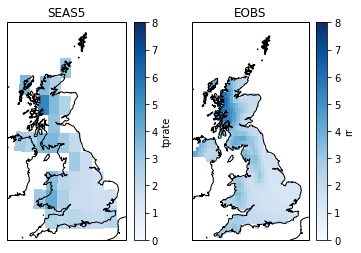

In [57]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.OSGB()})

SEAS5['tprate'].where(SEAS5_mask == 31).mean(
    dim=['time', 'leadtime', 'number']).plot(
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[0])

EOBS['rr'].where(EOBS_mask == 31).mean(dim='time').plot(
    transform=ccrs.PlateCarree(), 
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[1])

for ax in axs.flat:
    ax.coastlines(resolution='10m')

axs[0].set_title('SEAS5')
axs[1].set_title('EOBS')

#### Illustrate the SEAS5 and EOBS UK average

And the area-weighted average UK precipitation for SEAS5 and EOBS I plot here. For SEAS5 I plot the range, both min/max and the 2.5/97.5 % percentile of all ensemble members and leadtimes for each year.  

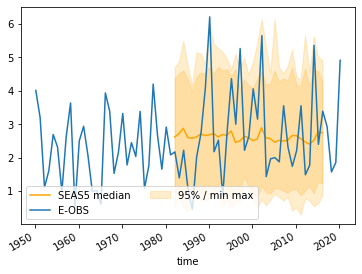

In [58]:
ax = plt.axes()

Quantiles = SEAS5_UK_weighted.quantile([0,2.5/100, 0.5, 97.5/100,1], dim=['number','leadtime'])
ax.plot(Quantiles.time, Quantiles.sel(quantile=0.5), color='orange',label = 'SEAS5 median')
ax.fill_between(Quantiles.time.values, Quantiles.sel(quantile=0.025), Quantiles.sel(quantile=0.975), color='orange', alpha=0.2,label = '95% / min max')
ax.fill_between(Quantiles.time.values, Quantiles.sel(quantile=0), Quantiles.sel(quantile=1), color='orange', alpha=0.2)

EOBS_UK_weighted.plot(ax=ax,x='time',label = 'E-OBS')

# Quantiles_EOBS = EOBS['rr'].where(EOBS_mask == 143).mean(dim = ['latitude','longitude']).quantile([2.5/100, 0.5, 97.5/100], dim=['time'])#.plot()
# ax.plot(EOBS.time, np.repeat(Quantiles_EOBS.sel(quantile=0.5).values,71), color='blue',linestyle = '--',linewidth = 1)
# ax.plot(EOBS.time, np.repeat(Quantiles_EOBS.sel(quantile=2.5/100).values,71), color='blue',linestyle = '--',linewidth = 1)
# ax.plot(EOBS.time, np.repeat(Quantiles_EOBS.sel(quantile=97.5/100).values,71), color='blue',linestyle = '--',linewidth = 1)

plt.legend(loc = 'lower left', ncol=2 )#loc = (0.1, 0) upper left


### Potential improvements

There are many different sources and methods available for extracting areal-averages from shapefiles. Here I have used shapely / masking in xarray. Something that lacks with this method is the weighted extraction from a shapefile, that is more precise on the boundaries. In R, raster:extract can use the percentage of the area that falls within the country for each grid cell to use as weight in averaging. For more information on this method, see the [EGU 2018 course](https://github.com/hydrosoc/rhydro_EGU18/blob/master/netCDF.pdf). For SEAS5, with its coarse resolution, this might make a difference. However, for it's speed and reproducibility, we have chosen to stick to xarray. 

We have used xarray where you can apply weights yourself to a dataset and then calculate the weighted mean. Sources I have used: [xarray weighted reductions](http://xarray.pydata.org/en/stable/computation.html#weighted-array-reductions) [Matteo's blog](http://www.matteodefelice.name/post/aggregating-gridded-data/) [regionmask package](https://regionmask.readthedocs.io/en/stable/#) [Arctic weighted average example](https://nordicesmhub.github.io/NEGI-Abisko-2019/training/Example_model_global_arctic_average.html) and [area weighted temperature example](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html).

Instead of xarray, the areal weighing can be done in [iris](https://www.wemcouncil.org/wp/wemc-tech-blog-4-5-calculating-nuts2-regional-averages-with-land-sea-mask/). It still doesn't solve the problem with country borders. Since I don't know iris and have been working in xarray, I have not further explored that method. 

Two options we could still explore to improve the extraction:

1. Do the extraction in R and compare it to the current xarray method. 
2. Upscale EOBS to the SEAS5 grid and then mask: We could regrid EOBS to the SEAS5 grid and then select the same gridcells for both datasets. The country outline would not be perfect, but the masks would be the same so the comparison would be fair. I think this method is most commonly applied in climate science, where you regrid all your xx datasets to the same grid so you can compare them. Pro: pragmatic. Con: not a perfect country definition. I explore this in [1.5Upscale] 
Source: This pretty [awesome colab notebook](https://colab.research.google.com/drive/1wWHz_SMCHNuos5fxWRUJTcB6wqkTJQCR#scrollTo=B8PyoC1vXvd-) on seasonal forecasting regrids seasonal forecasts and reanalysis on the same grid before calculating skill scores 
